# Leios simulation analysis at tag `leios-2025w28`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: stracciatella

In [2]:
label <- "Rust simulator, mini-mainnet, full-without-ibs, 1.0 EB/stage"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/stracciatella/lifecycle.Rdata")) {
    load(file="results/stracciatella/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/stracciatella/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(lifecycle, sampleSize, file="results/stracciatella/lifecycle.R")
}
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator           Stage length           TPS         Kind       
 Rust:804723   5 slot/stage:402495   1029 tx/s:617767   EB:   828  
               8 slot/stage:402228   237 tx/s :142683   RB:   255  
                                     73 tx/s  : 44273   TX:803640  
                                                                   
                                                                   
                                                                   
                                                                   
      Item           Size [B]        References      Created [s]   
 0      :     6   Min.   :     6   Min.   : 0.000   Min.   : 19.0  
 1      :     6   1st Qu.:   434   1st Qu.: 1.000   1st Qu.:134.9  
 10     :     6   Median :   930   Median : 1.000   Median :209.6  
 100    :     6   Mean   :  1752   Mean   : 1.467   Mean   :210.1  
 1000   :     6   3rd Qu.:  1993   3rd Qu.: 2.000   3rd Qu.:285.0  
 10000  :     6   Max.   :319248   Max.   :66.00

#### Range of transaction injection

In [4]:
txFirst <- 60
txLast <- 360
txWindow <- txLast - txFirst
simFinish <- 900

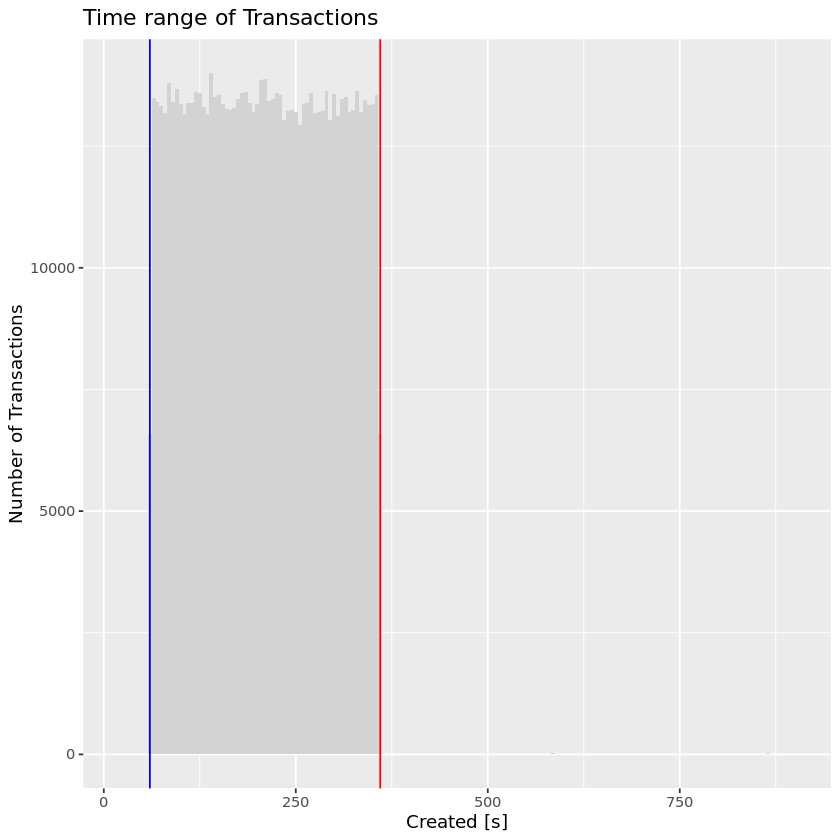

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow
    ),
    .(`Stage length`, `TPS`)
]

Stage length,TPS,Demand [tx/s],Demand [MB/s]
<fct>,<fct>,<dbl>,<dbl>
8 slot/stage,73 tx/s,73.18667,0.1243095
8 slot/stage,237 tx/s,237.20000,0.4051060
8 slot/stage,1029 tx/s,1029.01000,1.7539023
5 slot/stage,73 tx/s,73.18667,0.1243095
5 slot/stage,237 tx/s,237.20333,0.4051082
5 slot/stage,1029 tx/s,1029.01000,1.7539023


#### Size of persisted data

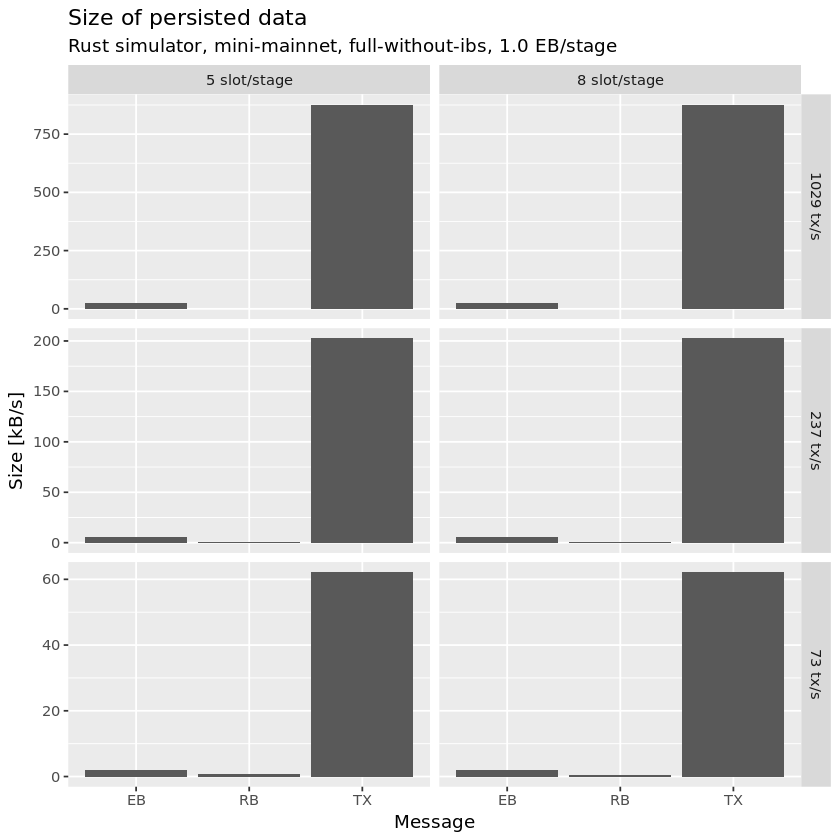

In [7]:
ggplot(
    lifecycle[,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        .(`Message`=`Kind`, `Stage length`, `TPS`)
    ],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_grid(`TPS` ~ `Stage length`, scales="free_y") +
    ggtitle("Size of persisted data", subtitle=label)

In [8]:
ggsave("plots/stracciatella/sizes.png", units="in", dpi=150, width=8, height=6)

In [9]:
ggsave("plots/stracciatella/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

In [10]:
lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Stage length`, `TPS`)
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric((`Kind` != "VT") * `Size [B]`))), 
            .(`Stage length`, `TPS`)
        ],
        on=c("Stage length", "TPS")
    ][, .(`Stage length`, `TPS`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)]

Stage length,TPS,Space efficiency [%]
<fct>,<fct>,<dbl>
8 slot/stage,73 tx/s,96.06798
8 slot/stage,237 tx/s,96.78392
8 slot/stage,1029 tx/s,97.37155
5 slot/stage,73 tx/s,94.98354
5 slot/stage,237 tx/s,96.11551
5 slot/stage,1029 tx/s,96.92297


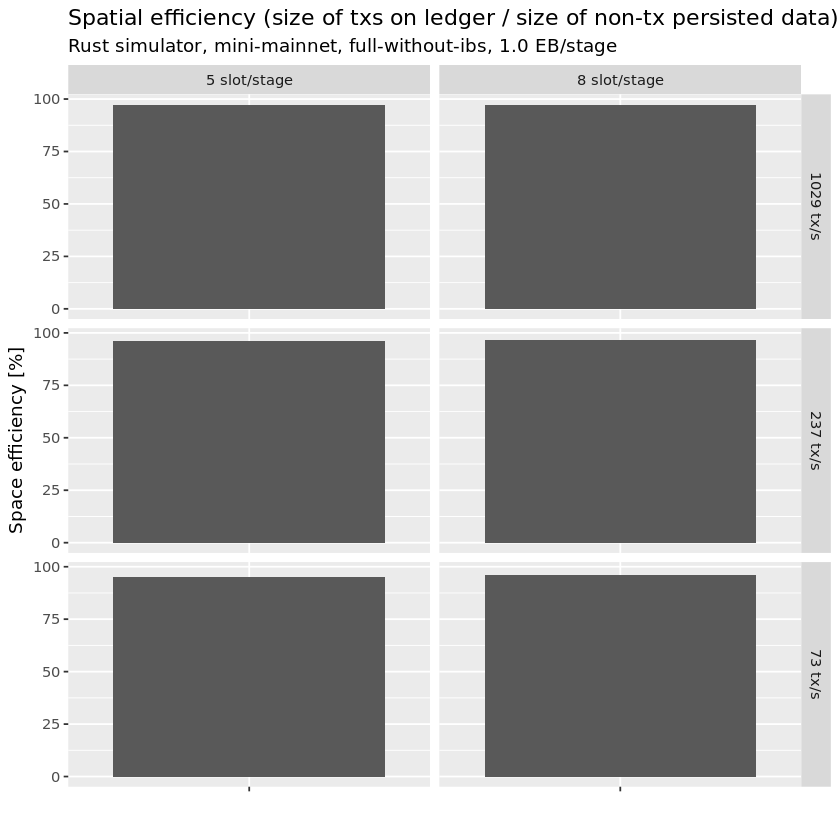

In [11]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Stage length`, `TPS`)
    ][
        lifecycle[
            `Kind` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Stage length`, `TPS`)
        ],
        on=c("Stage length", "TPS")
    ][, .(`Stage length`, `TPS`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x="", y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_grid(`TPS` ~ `Stage length`) +
    xlab("") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [12]:
ggsave("plots/stracciatella/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [13]:
ggsave("plots/stracciatella/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

In [14]:
lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`To RB [s]`-`Created [s]`)), 
        .(`Stage length`, `TPS`)
    ]

Stage length,TPS,Time to reach ledger [s]
<fct>,<fct>,<dbl>
8 slot/stage,73 tx/s,55.14224
8 slot/stage,237 tx/s,55.13118
8 slot/stage,1029 tx/s,124.62586
5 slot/stage,73 tx/s,106.61941
5 slot/stage,237 tx/s,106.70299
5 slot/stage,1029 tx/s,106.86737


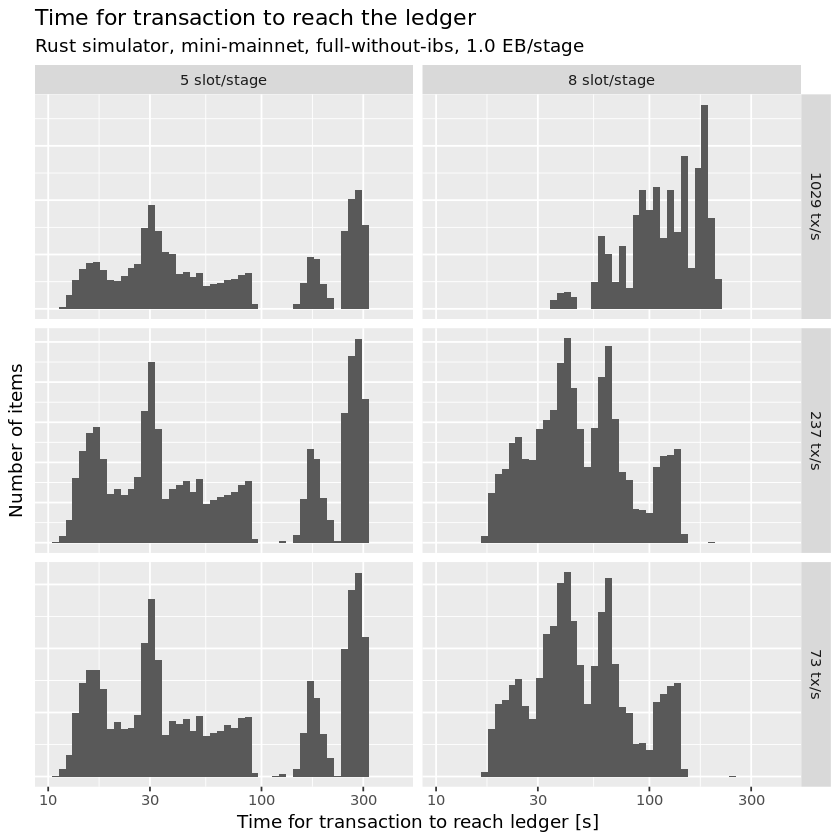

In [15]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Stage length`, `TPS`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    scale_x_log10() +
    facet_grid(`TPS` ~ `Stage length`, scales="free_y") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [16]:
ggsave("plots/stracciatella/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [17]:
ggsave("plots/stracciatella/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

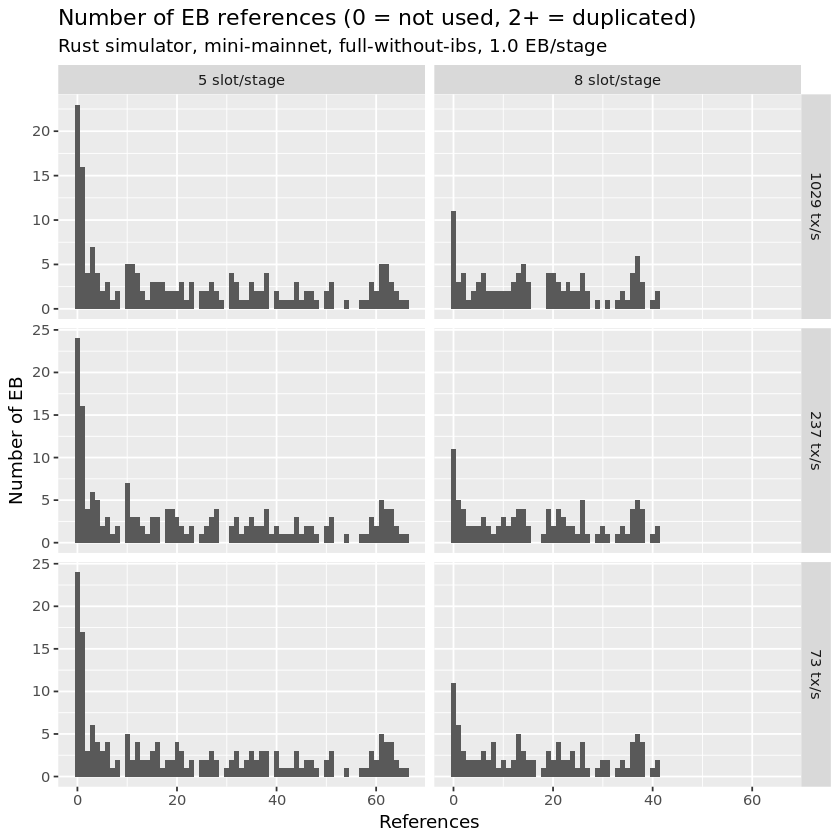

In [18]:
ggplot(
    lifecycle[
        `Kind` == "EB",
        .(`References`),
        .(`Stage length`, `TPS`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`TPS` ~ `Stage length`, scales="free_y") +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)", label)

In [19]:
ggsave("plots/stracciatella/references-tx.png", units="in", dpi=150, width=8, height=6)

In [20]:
ggsave("plots/stracciatella/references-tx.svg", units="in", dpi=150, width=8, height=6)

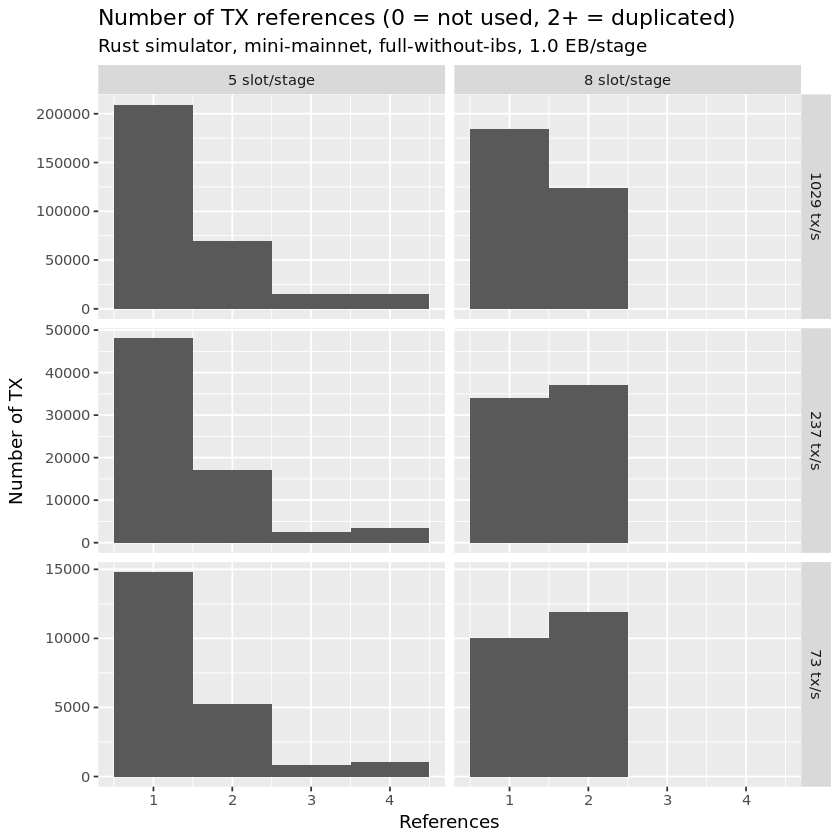

In [21]:
ggplot(
    lifecycle[
        `Kind` == "TX",
        .(`References`),
        .(`Stage length`, `TPS`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`TPS` ~ `Stage length`, scales="free_y") +
    ylab("Number of TX") +
    ggtitle("Number of TX references (0 = not used, 2+ = duplicated)", label)

In [22]:
ggsave("plots/stracciatella/references-tx.png", units="in", dpi=150, width=8, height=6)

In [23]:
ggsave("plots/stracciatella/references-tx.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [24]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [25]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Stage length`, `TPS`
    )
][order(`Stage length`, `TPS`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [26]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Stage length`, `TPS`, `Submitted [minute]`)]

#### Transactions reaching the ledger

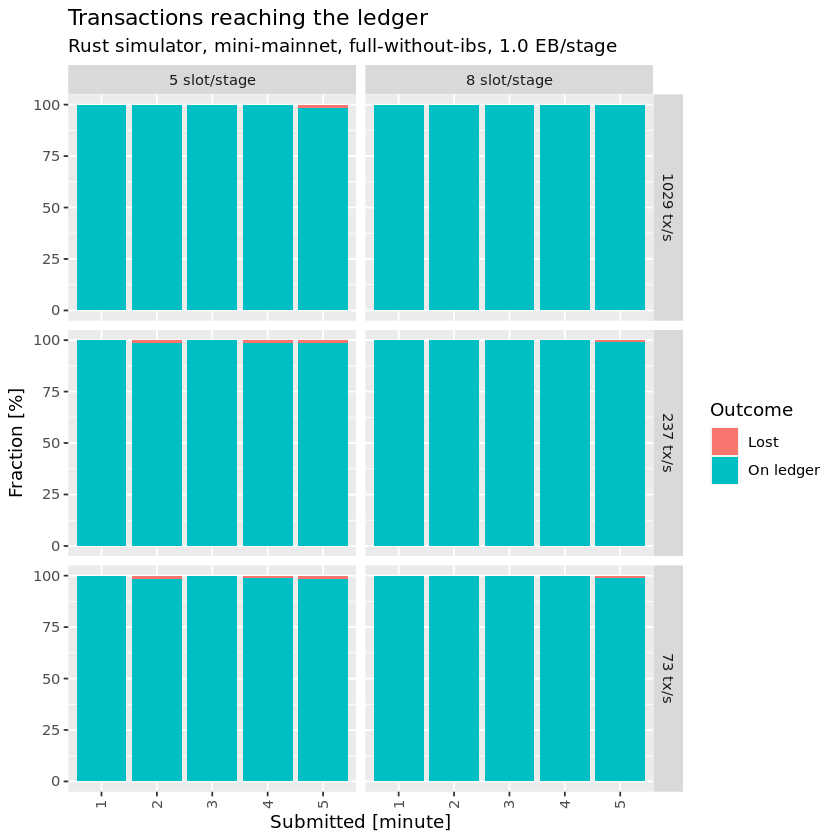

In [27]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Stage length`, `TPS`, `Submitted [minute]`)],
        id.vars=c("Stage length", "TPS", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[`Submitted [minute]` != 6, .(
        `Stage length`, 
        `TPS`,
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`TPS` ~ `Stage length`) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [28]:
ggsave("plots/stracciatella/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [29]:
ggsave("plots/stracciatella/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

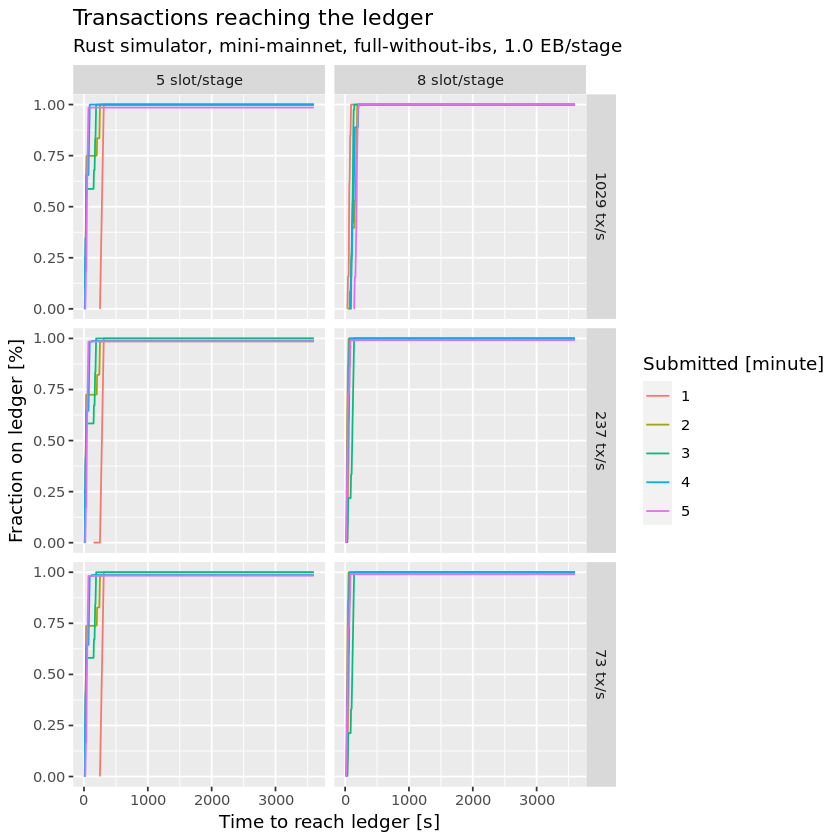

In [30]:
ggplot(
    rbind(
        totals[
            outcomes[
                !is.na(`Time to reach ledger [s]`), 
                .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), 
                .(`Stage length`, `TPS`, `Submitted [minute]`)
            ],
            on=c("Stage length", "TPS", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Stage length`, `TPS`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Stage length`, `TPS`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 6],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_grid(`TPS` ~ `Stage length`) +
    ggtitle("Transactions reaching the ledger", label)

In [31]:
ggsave("plots/stracciatella/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [32]:
ggsave("plots/stracciatella/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [33]:
rm(lifecycle, outcomes, totals)

In [34]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,973960,52.1,2782662,148.7,2782662,148.7
Vcells,4786905,36.6,45817691,349.6,57272113,437.0


### Resource usage

In [35]:
if (file.exists("results/stracciatella/resources.Rdata")) {
    load(file="results/stracciatella/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/stracciatella/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(resources, file="results/stracciatella/resources.Rdata")
}
resources %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator         Stage length         TPS             Node     
 Rust:4500   5 slot/stage:2250   1029 tx/s:1500   node-0  :   6  
             8 slot/stage:2250   237 tx/s :1500   node-1  :   6  
                                 73 tx/s  :1500   node-10 :   6  
                                                  node-100:   6  
                                                  node-101:   6  
                                                  node-102:   6  
                                                  (Other) :4464  
   Egress [B]           Disk [B]      Total CPU [s]   Maximum CPU [s/s]
 Min.   :1.722e+04   Min.   :     0   Min.   :22.71   Min.   :0.3535   
 1st Qu.:9.750e+06   1st Qu.:     0   1st Qu.:26.33   1st Qu.:0.5983   
 Median :6.252e+07   Median :     0   Median :38.76   Median :0.6081   
 Mean   :2.311e+08   Mean   :  8882   Mean   :37.49   Mean   :0.6874   
 3rd Qu.:2.566e+08   3rd Qu.:     0   3rd Qu.:41.75   3rd Qu.:0.7894   
 Max.   :3.392e+09   Max.   :920048   Ma

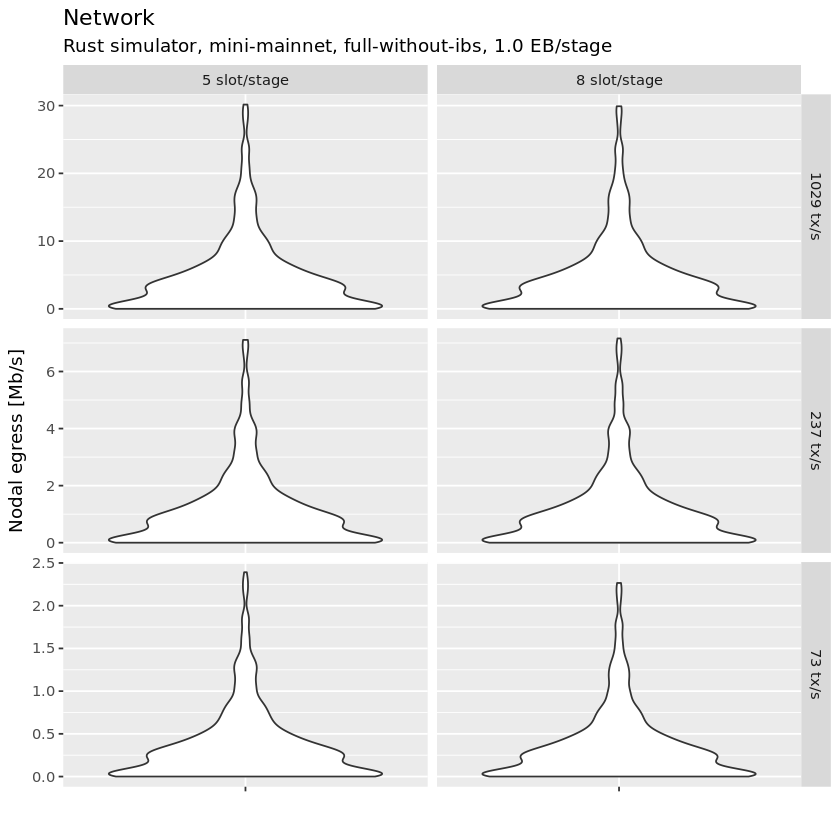

In [36]:
ggplot(
    resources[, .(`Stage length`, `TPS`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_grid(`TPS` ~ `Stage length`, scales="free_y") +
    xlab("") +
    ggtitle("Network", label)

In [37]:
ggsave("plots/stracciatella/network.png", units="in", dpi=150, width=9.5, height=5.5)

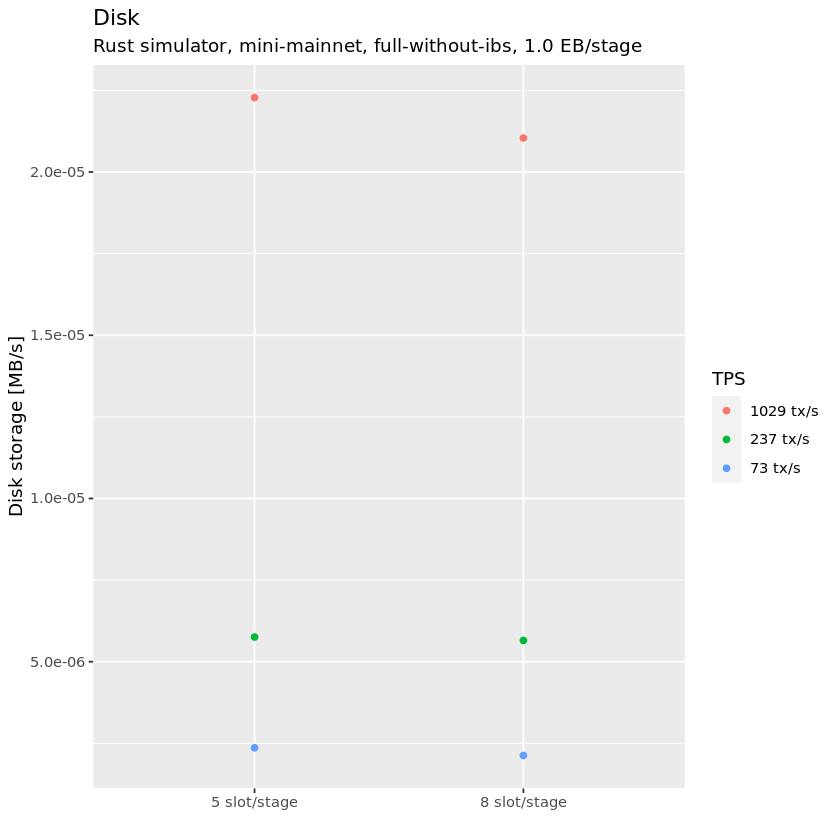

In [38]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Stage length`, `TPS`)],
    aes(x=`Stage length`, color=`TPS`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    xlab("") +
    ggtitle("Disk", label)

In [39]:
ggsave("plots/stracciatella/disk.png", units="in", dpi=150, width=9.5, height=5.5)

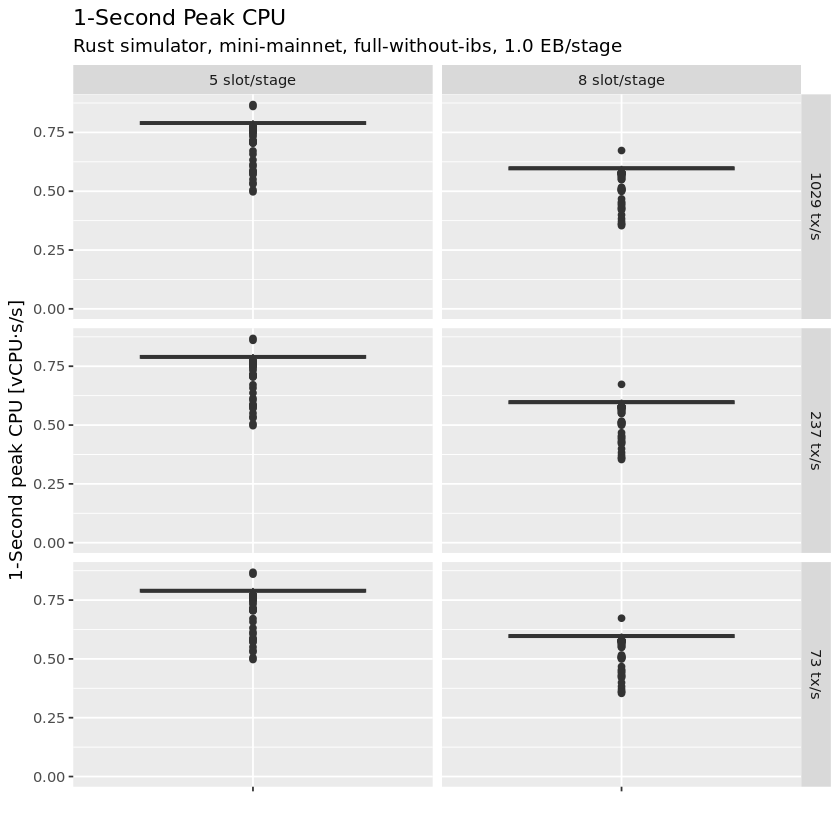

In [40]:
ggplot(
    resources[, .(`Node`, `Stage length`, `TPS`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`TPS` ~ `Stage length`) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [41]:
ggsave("plots/stracciatella/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

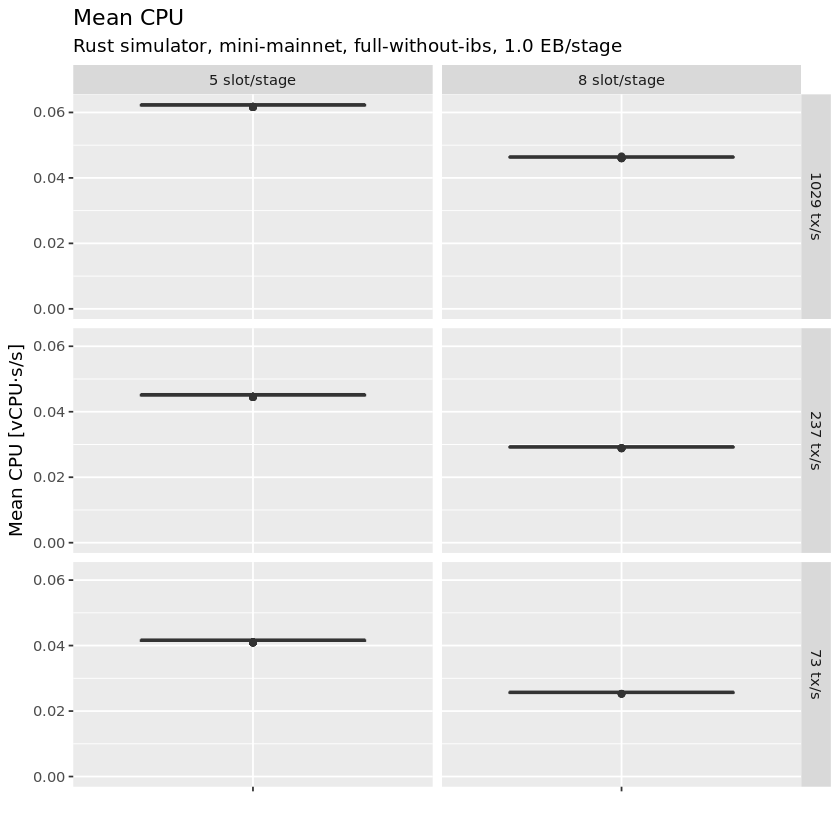

In [42]:
ggplot(
    resources[, .(`Stage length`, `TPS`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`TPS` ~ `Stage length`) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [43]:
ggsave("plots/stracciatella/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [44]:
rm(resources)

In [45]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1004019,53.7,2782662,148.7,2782662,148.7
Vcells,2044854,15.7,36654153,279.7,57272113,437.0


### Receipt of messages

#### Read results

In [46]:
if (file.exists("results/stracciatella/receipts.Rdata")) {
    load("results/stracciatella/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/stracciatella/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(receipts, file="results/stracciatella/receipts.Rdata")
}
receipts %>% summary

Loaded Rdata file: sampleSize = 0.25 


 Simulator              Stage length             TPS            Kind          
 Rust:169550354   5 slot/stage:86542611   1029 tx/s:121978301   EB:   154635  
                  8 slot/stage:83007743   237 tx/s : 33000651   RB:    47589  
                                          73 tx/s  : 14571402   TX:150495505  
                                                                VT: 18852625  
                                                                              
                                                                              
                                                                              
           Item               Producer         Generated [s]      Size [B]     
 360-node-143:     1750   node-539:   410074   Min.   : 19.0   Min.   :     6  
 280-node-573:     1710   node-381:   403539   1st Qu.:139.7   1st Qu.:   314  
 160-node-176:     1707   node-307:   309518   Median :219.8   Median :   778  
 720-node-600:     1707   node-614:   303116   M

In [47]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [48]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Stage length`, `TPS`, `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`TPS` ~ `Stage length`, scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

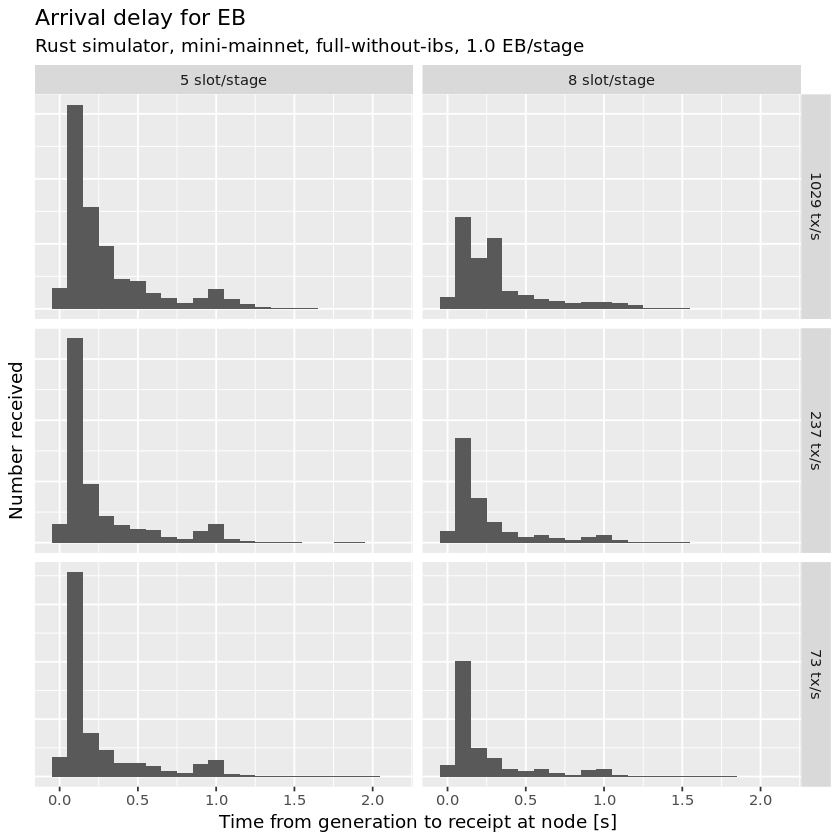

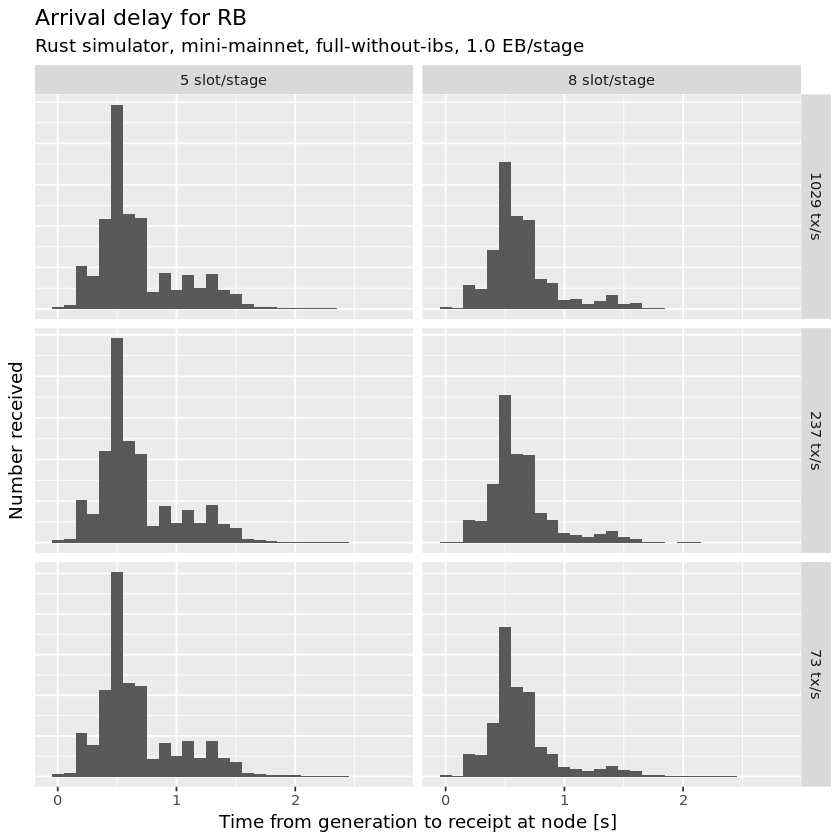

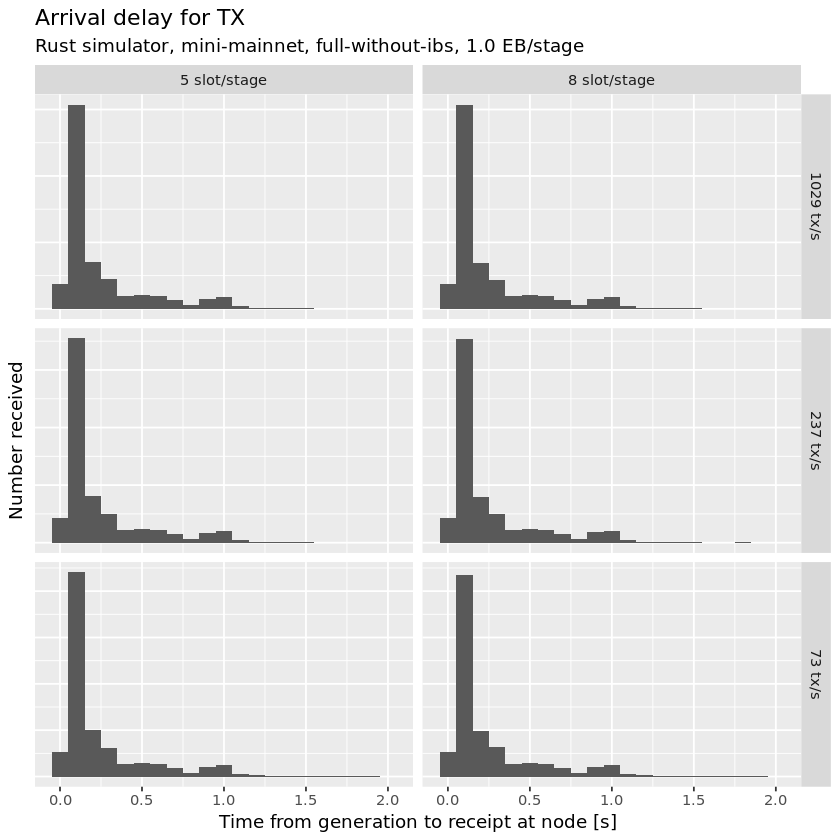

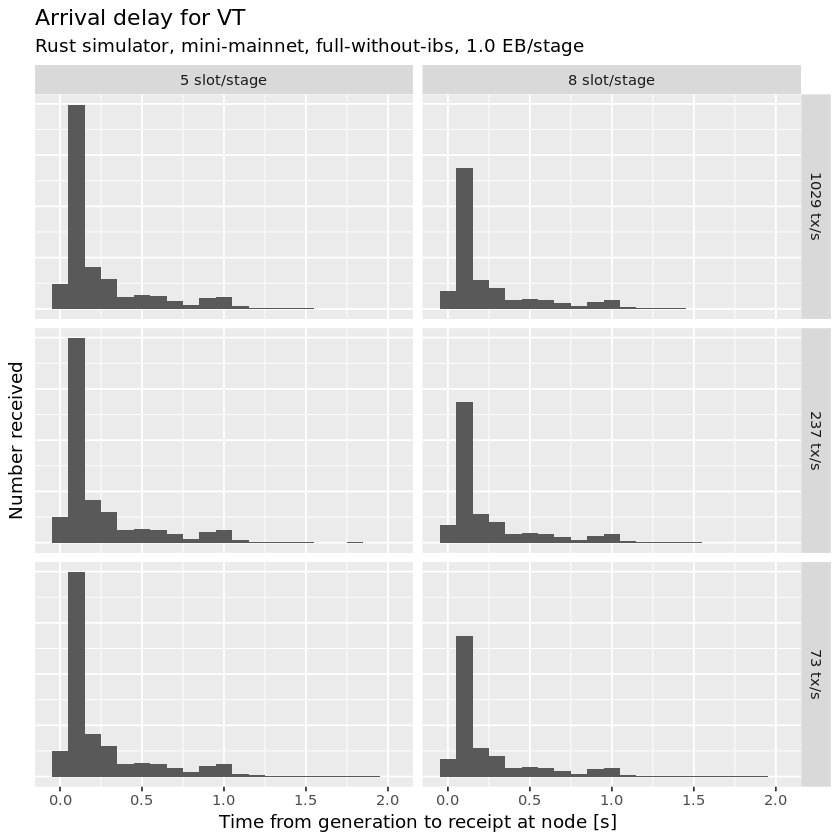

In [49]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/stracciatella/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [50]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Stage length`, `TPS`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Stage length`, `TPS`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)/sampleSize),
            by=.(`Stage length`, `TPS`, `Generated [s]`)
        ][, .(`Stage length`, `TPS`, `Generated [s]`,`Received`)
        ], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`TPS` ~ `Stage length`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

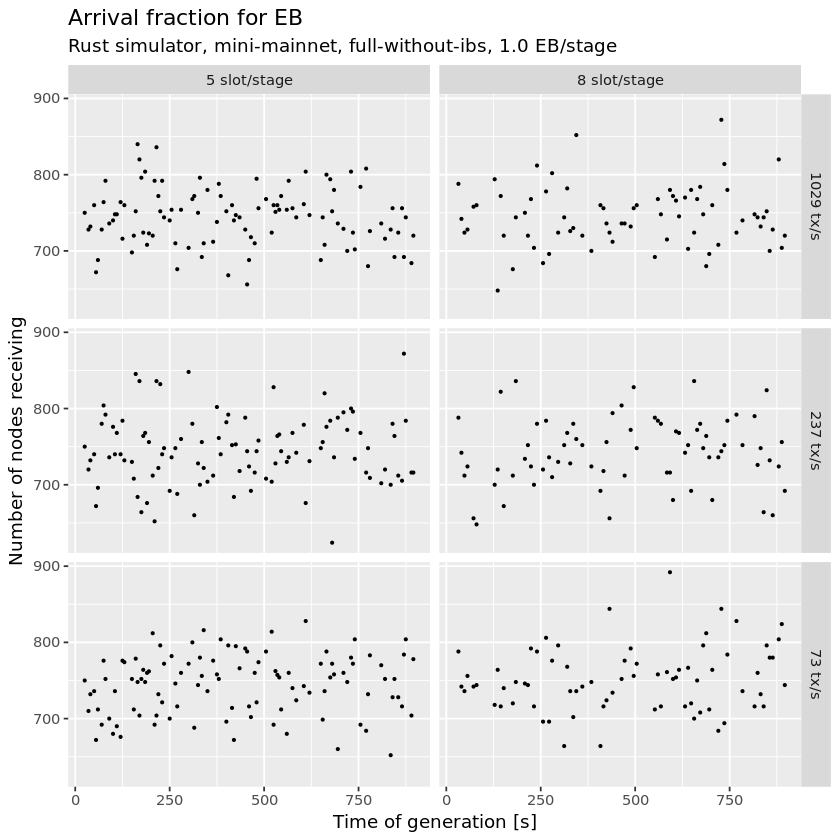

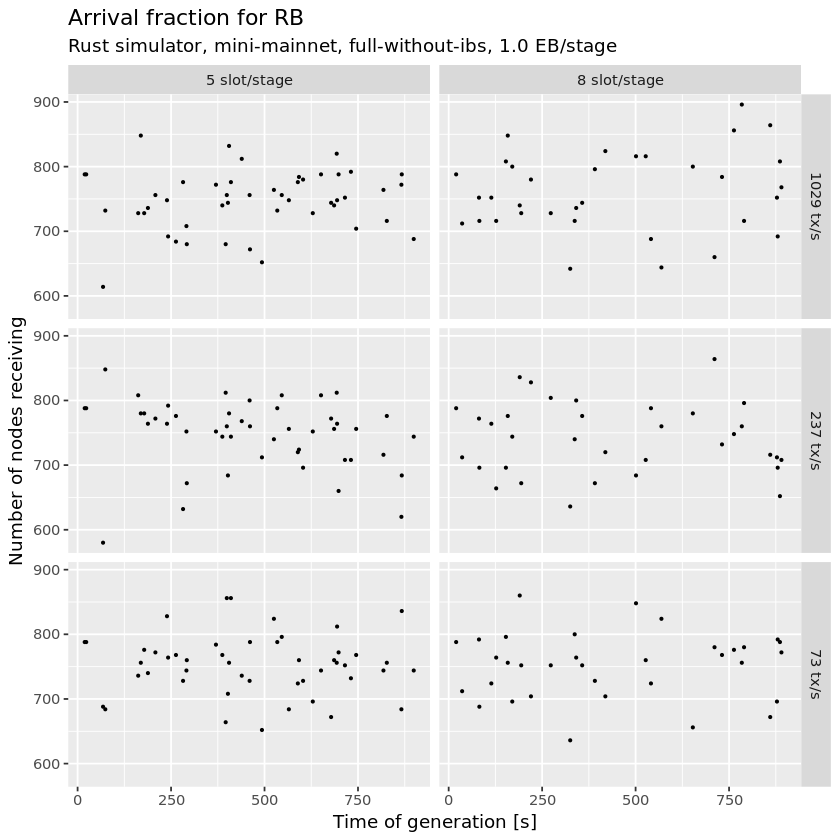

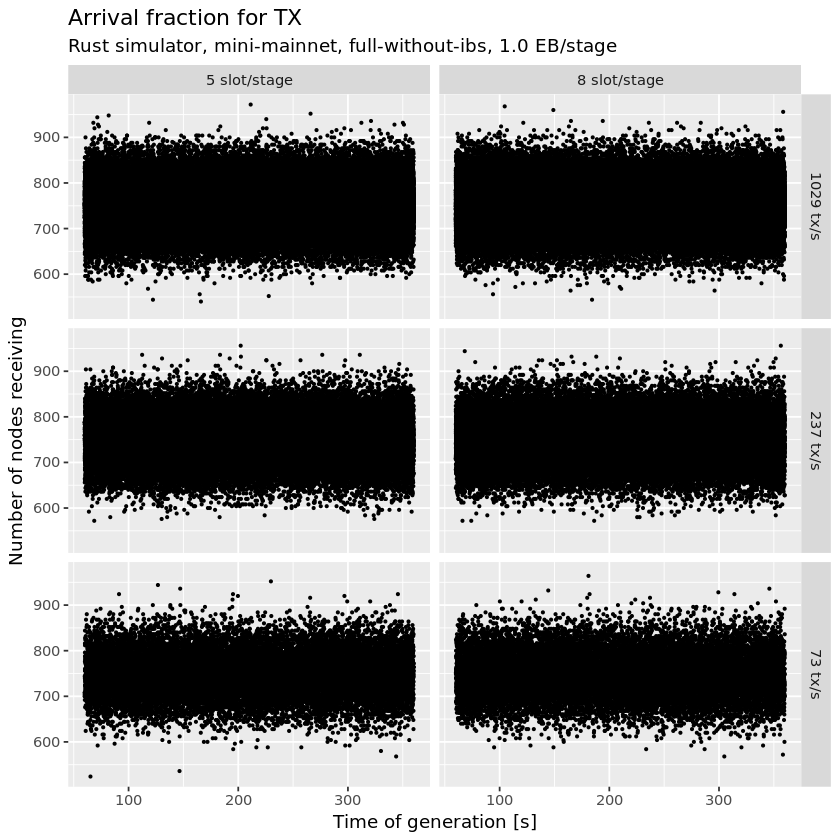

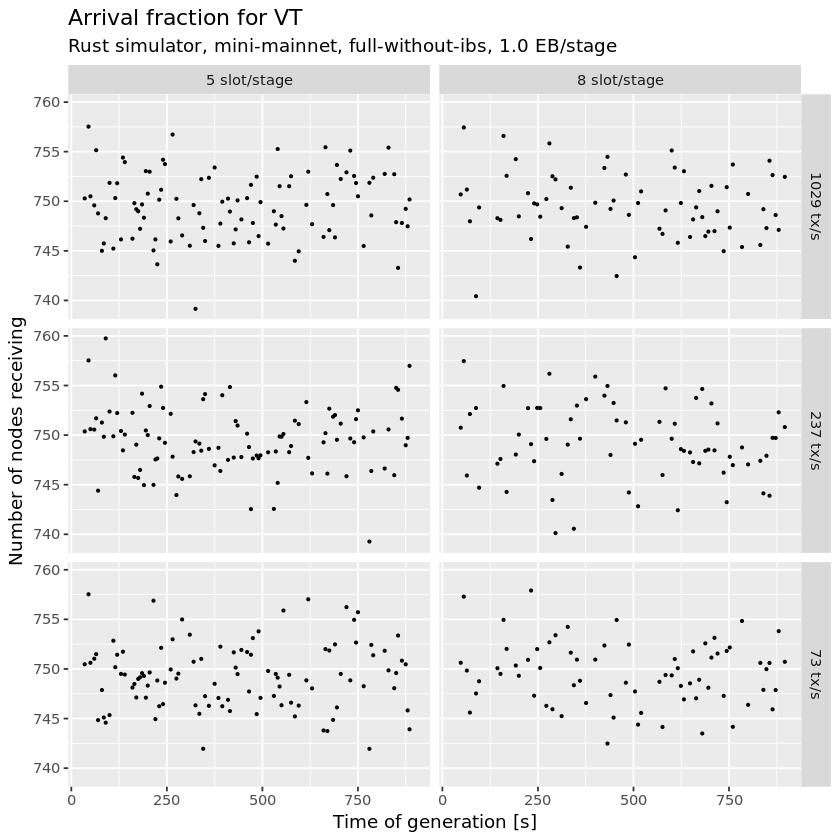

In [51]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/stracciatella/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [52]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
            by=.(`Stage length`, `TPS`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`TPS` ~ `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

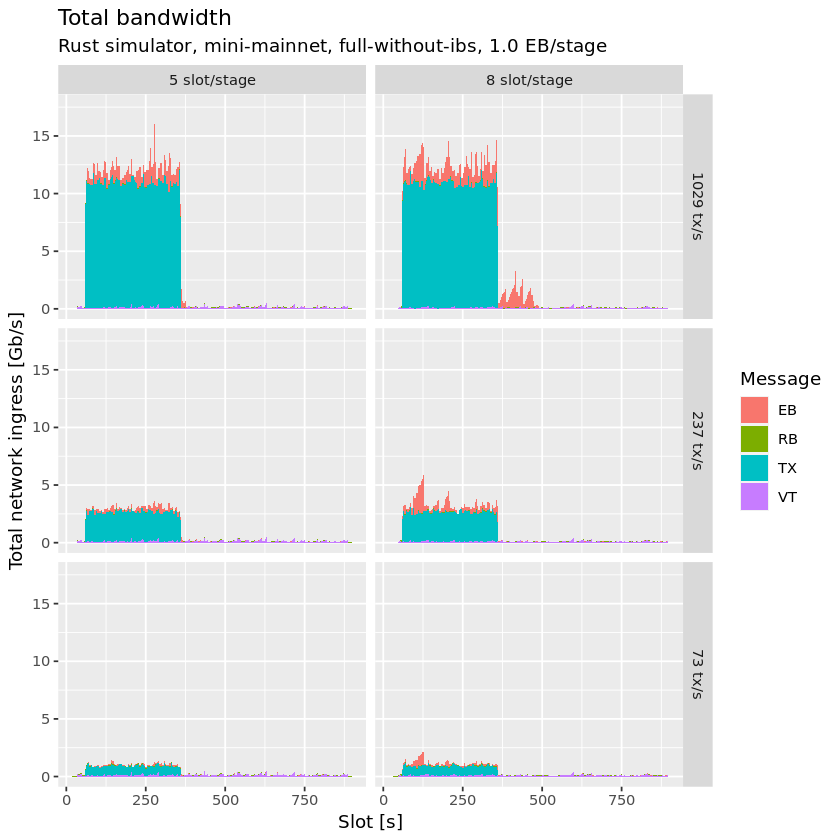

In [53]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/stracciatella/ingress-total-area.png")
)

##### Bandwidth usage per node

In [54]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [55]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount/sampleSize),
            by=.(`Stage length`, `TPS`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`TPS` ~ `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

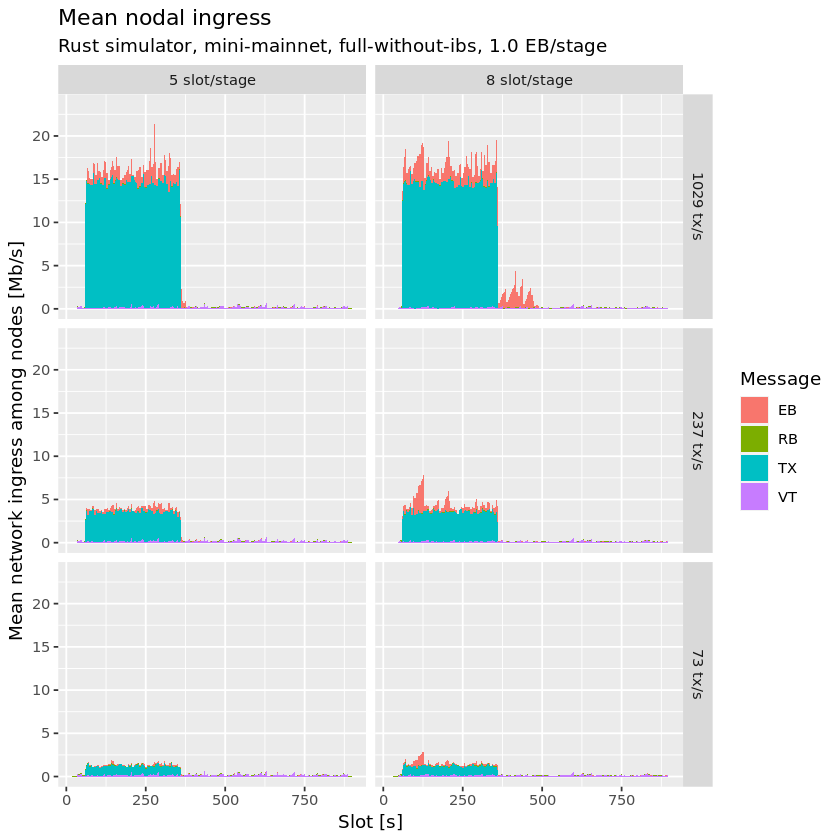

In [56]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/stracciatella/ingress-average-area.png")
)

In [57]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
            by=.(`Stage length`, `TPS`, `Slot`=floor(`Received [s]`), `Message`=`Kind`, `Recipient`)
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Stage length`, `TPS`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`TPS` ~ `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

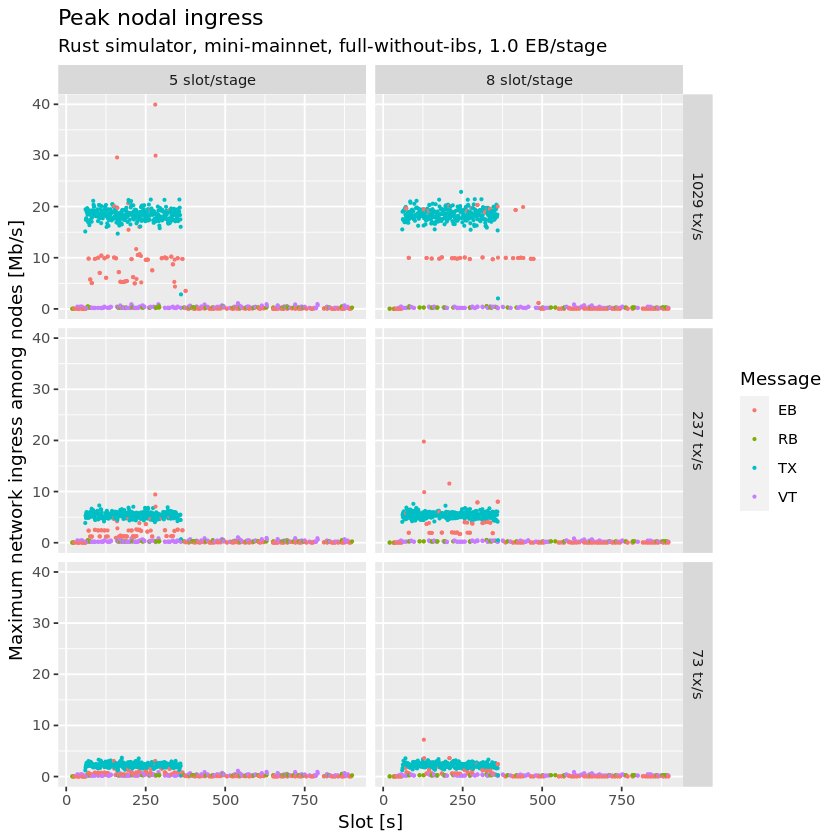

In [58]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/stracciatella/ingress-peak-point.png")
)

#### Release memory

In [59]:
rm(receipts)

In [60]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1356585,72.5,2782662,148.7,2782662,148.7
Vcells,1274415979,9723.1,3512663736,26799.5,5488537086,41874.3


### CPU usage

#### Read results

In [61]:
if (file.exists("results/stracciatella/cpus.Rdata")) {
    load(file="results/stracciatella/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/stracciatella/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(cpus, file="results/stracciatella/cpus.Rdata")
}
cpus %>% summary

Loaded Rdata file: sampleSize = 0.25 


 Simulator              Stage length             TPS                 Slot      
 Rust:180098240   5 slot/stage:94053194   1029 tx/s:125494125   Min.   : 19.0  
                  8 slot/stage:86045046   237 tx/s : 36516129   1st Qu.:143.0  
                                          73 tx/s  : 18087986   Median :226.0  
                                                                Mean   :250.5  
                                                                3rd Qu.:310.0  
                                                                Max.   :900.0  
                                                                               
       Node                Task            Duration [s]      
 node-221:   241835   GenEB  :      205   Min.   :0.0000650  
 node-158:   241590   GenRB  :       47   1st Qu.:0.0000650  
 node-592:   241516   GenVote:    39064   Median :0.0000650  
 node-326:   241403   ValEB  :   154863   Mean   :0.0002341  
 node-609:   241402   ValRB  :    47221   3rd Qu.:

In [62]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Stage length`, `TPS`, `Node`, `Slot`)
]

In [63]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [64]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Stage length`, `TPS`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`TPS` ~ `Stage length`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

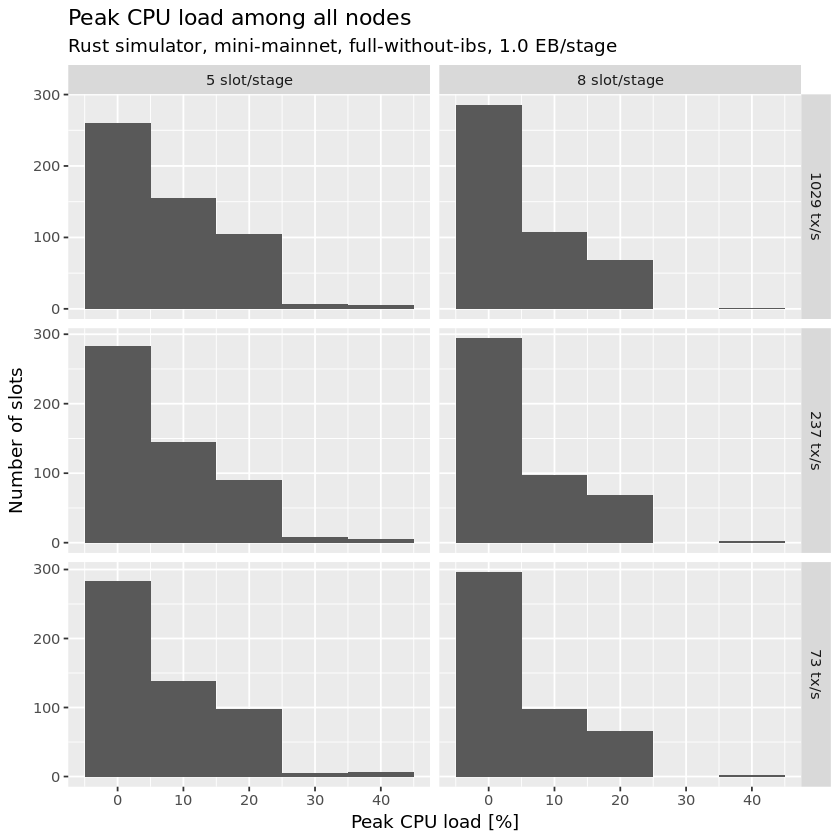

In [65]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/stracciatella/cpu-peak-histogram.png")
)

##### Time series

In [66]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
            by=.(`Stage length`, `TPS`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`TPS` ~ `Stage length`, scale=scales) +
#       scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

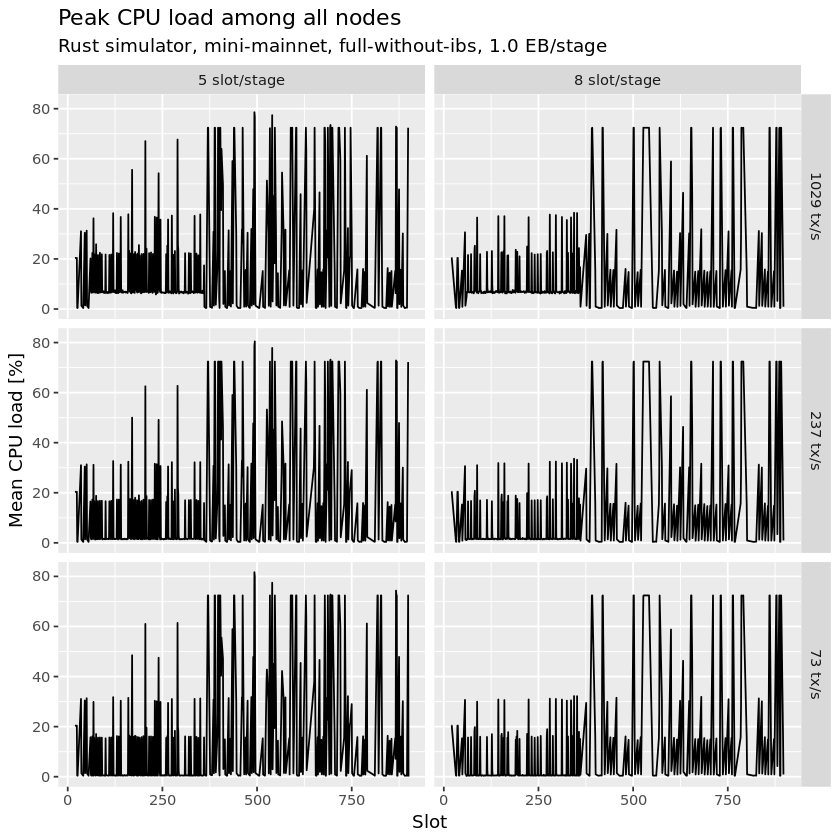

In [67]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/stracciatella/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [68]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Stage length`, `TPS`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`TPS` ~ `Stage length`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

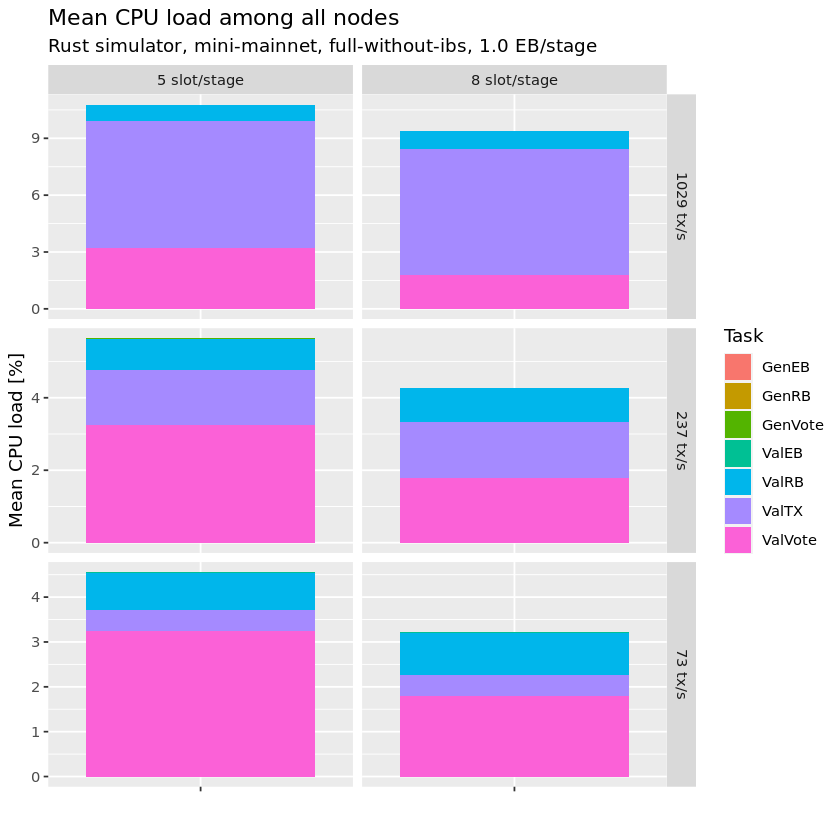

In [69]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/stracciatella/cpu-mean-histogram.png")
)

##### Time series

In [70]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Stage length`, `TPS`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`TPS` ~ `Stage length`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

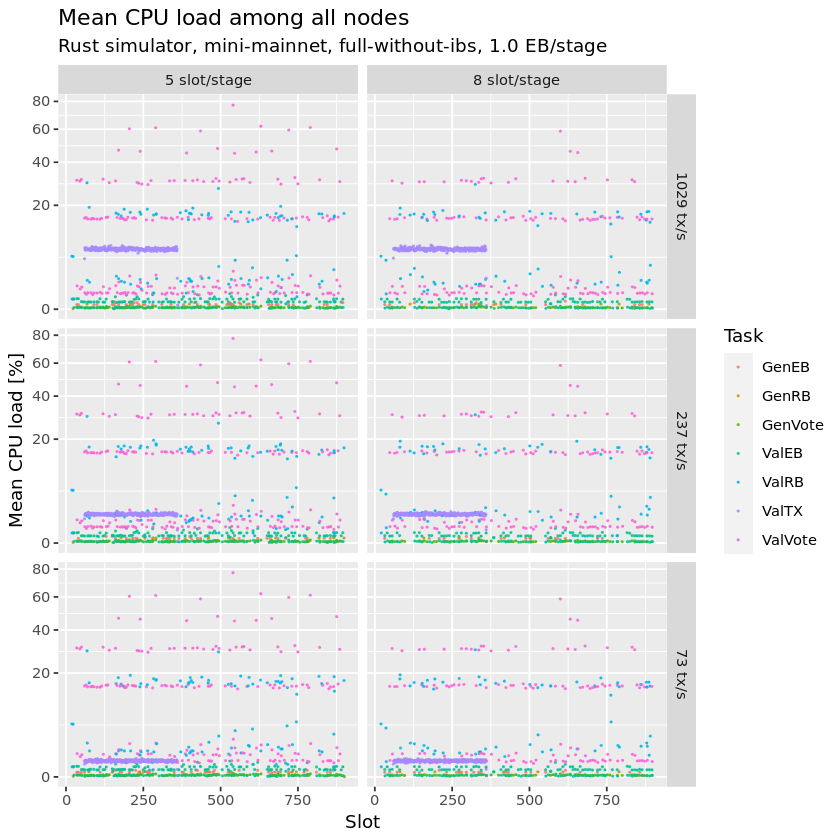

In [71]:
meanCpuTimeseries(
    cpus, 
    nodeCount * sampleSize, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/stracciatella/cpu-mean-timeseries.png")
)

#### Release memory

In [72]:
rm(cpus, cpusNode)

In [73]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1018695,54.5,2782662,148.7,2782662,148.7
Vcells,722471902,5512.1,2248104792,17151.7,5488537086,41874.3
